<a href="https://colab.research.google.com/github/david-adewoyin/UNet/blob/main/unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from os import listdir
import tensorflow as tf
import tensorflow.keras as keras
from  tensorflow.keras import layers

from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping
import matplotlib.pyplot as plt

In [ ]:
EPOCHS = 40
BUFFER_SIZE = 500
BATCH_SIZE = 8

IMG_HEIGHT = 256
IMG_WIDTH = 256

image_dir = "/content/CameraRGB/"
masks_dir = "/content/CameraSeg/"

images_list = listdir(image_dir)
masks_list = listdir(masks_dir)

images_path =  [image_dir + i  for i in  images_list]
masks_path  = [masks_dir + i  for i in masks_list]

In [ ]:
def load_images(image_path, mask_path, img_size = (256,256)):
  img_data = tf.io.read_file(image_path)
  img = tf.io.decode_png(img_data,channels=3)
  img = tf.image.convert_image_dtype(img,tf.float32)

  segm_data = tf.io.read_file(mask_path)
  mask = tf.io.decode_png(segm_data)
  mask = tf.math.reduce_max(mask, axis = -1, keepdims=True)

  img = tf.image.resize(img, img_size , method = 'nearest')
  mask = tf.image.resize(mask,img_size, method = 'nearest')
  
  return img, mask

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((images_path,masks_path))
dataset = dataset.map(load_images ,num_parallel_calls = tf.data.AUTOTUNE).batch(BATCH_SIZE).shuffle(BUFFER_SIZE).cache()

In [ ]:
val_dataset = (dataset
               .take(100)
               .prefetch(buffer_size=tf.data.AUTOTUNE)
                )
train_dataset = (dataset
               .skip(100)
               .prefetch(buffer_size=tf.data.AUTOTUNE)
                ) 
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.uint8, name=None))>

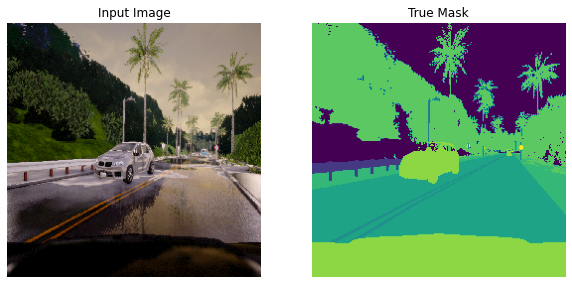

In [ ]:
# plot images
def display(display_list):
  plt.figure(figsize=(10,10))
  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
    
N = 1
for image,mask in dataset.take(N):
  sample_image, sample_mask = image,mask
  display([sample_image,sample_mask])
  

## Unet Model
The Unet Architecture consists of a contracting path (left side) and an expansive (right path).The contracting path follows the typical architecure of a regular convolutional network


In [ ]:
class DoubleConv(keras.layers.Layer):

  """ (convolution => [BN] => Relu) *2 
  Each step in the contracting and expansive path have two 3x3 convolutional layer
  In the U-Nnet padding they used 0 padding but we use 1 padding so that we don't crop the final feature map
  """
  def __init__(self,filters):
    super(DoubleConv,self).__init__()

    # First 3x3 convolutional layer
    self.first = layers.Conv2D(filters, kernel_size = 3, padding='same', kernel_initializer = 'he_normal')
    self.batch1 = layers.BatchNormalization()
    self.act1 = layers.Activation('relu')

    # 2nd 3x3 convolutional layer
    self.second= layers.Conv2D(filters, kernel_size = 3, padding='same', kernel_initializer = 'he_normal')
    self.batch2 = layers.BatchNormalization()
    self.act2 = layers.Activation('relu')

  def call(self,inputs):
    # Apply the two convolutional layers
    x = self.first(inputs)
    x = self.batch1(x)
    x = self.act1(x)

    x = self.second(x)
    x = self.batch2(x)
    return self.act2(x)

class DownSampling(keras.layers.Layer):
  """ downsamples the feature map with a maxpool layer(2) followed by a double conv """

  def __init__(self,filters):
    super(DownSampling,self).__init__()
    # Max pooling Layer
    self.pool = layers.MaxPooling2D(2)
    self.conv = DoubleConv(filters)

  def call(self,inputs):
    x = self.pool(inputs)
    return self.conv(x)

class UpSampling(keras.layers.Layer):
  """Each Step in the expansive path up-samples the feature map with a 2x2 convolution follwed a double conv"""

  def __init__(self,filters):
    super(UpSampling,self).__init__()
    self.up = layers.Conv2DTranspose(filters, kernel_size = 2, strides = 2, padding = 'same', kernel_initializer = 'he_normal')
    self.conv = DoubleConv(filters)
  
  def call(self,inputs,corresponding_map):
   upsamp = self.up(inputs)
 
   crop = layers.CenterCrop(upsamp.shape[1],upsamp.shape[2])(corresponding_map)
   x = layers.Concatenate()([upsamp,crop])
   return self.conv(x)

In [ ]:
class UNet(keras.Model):

  def __init__(self, num_classes = 23):
      
    super(UNet,self).__init__()
    self.inc = DoubleConv(filters=64)
    self.down1 = DownSampling(filters=128)
    self.down2 = DownSampling(filters=256)
    self.down3 = DownSampling(filters=512)
    self.down4 = DownSampling(filters = 1024)

    self.up1 = UpSampling(filters = 1024)
    self.up2 = UpSampling(filters = 512)
    self.up3 = UpSampling(filters = 256)
    self.up4 = UpSampling(filters = 128)

    self.out = DoubleConv(filters=64)

    # final prediction classes
    self.outc = layers.Conv2D(num_classes, kernel_size = 1,padding='same')

  def call(self,inputs):
    #input =  layers.Input(shape =(256,256,3))(inputs) #self.first(inputs)
    skip1 = self.inc(inputs)
    skip2 = self.down1(skip1)
    skip3 = self.down2(skip2)
    skip4 = self.down3(skip3)

    x = self.down4(skip4)

    x = self.up1(x,skip1)
    x = self.up2(x,skip2)
    x = self.up3(x,skip3)
    x = self.up4(x,skip4)
    
    x = self.out(x)
    
    return self.outc(x)

In [ ]:
model = UNet(input_shape = (IMG_HEIGHT,IMG_WIDTH,3), num_classes = 23 )
model.compile(
     optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'],
  )

In [ ]:
callbacks = [
    ReduceLROnPlateau(patience=3, verbose=1),
    EarlyStopping(patience=12, verbose=1),
    ModelCheckpoint('unet-model.h5', verbose=0, save_best_only=True,save_weights_only=True)
    ]

In [ ]:
  # fiting the model
history = model.fit(
      train_dataset,
      epochs=EPOCHS,
      validation_data = val_dataset,
      validation_steps = 8,
      callbacks = callbacks, 
    )

Epoch 1/40
25/25 [==============================] - 37s 1s/step - loss: 0.2597 - accuracy: 0.9177 - val_loss: 1.5927 - val_accuracy: 0.6836 - lr: 0.0010
Epoch 2/40
25/25 [==============================] - 38s 2s/step - loss: 0.2434 - accuracy: 0.9213 - val_loss: 1.1384 - val_accuracy: 0.7171 - lr: 0.0010
Epoch 3/40
25/25 [==============================] - 38s 2s/step - loss: 0.2256 - accuracy: 0.9261 - val_loss: 1.1508 - val_accuracy: 0.7333 - lr: 0.0010
Epoch 4/40
25/25 [==============================] - 38s 2s/step - loss: 0.2152 - accuracy: 0.9293 - val_loss: 0.9197 - val_accuracy: 0.7909 - lr: 0.0010
Epoch 5/40
25/25 [==============================] - 39s 2s/step - loss: 0.1981 - accuracy: 0.9344 - val_loss: 0.7233 - val_accuracy: 0.8143 - lr: 0.0010
Epoch 6/40
25/25 [==============================] - 38s 2s/step - loss: 0.1761 - accuracy: 0.9417 - val_loss: 0.8082 - val_accuracy: 0.7952 - lr: 0.0010
Epoch 7/40
25/25 [==============================] - 39s 2s/step - loss: 0.1601 - a

In [ ]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

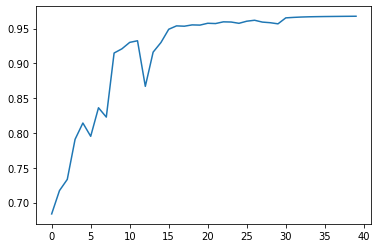

In [ ]:
plt.plot(history.history["val_accuracy"])

In [6]:
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])